In [5]:
import json

correct_example_file = 'w_2_demos_correct.json'
incorrect_example_file = 'w_2_demos_wrong.json'

with open(correct_example_file, 'r') as f:
    correct_examples = json.load(f)

with open(incorrect_example_file, 'r') as f:
    incorrect_examples = json.load(f)

model_name = 'gpt2-xl'


In [6]:
# tp, tn, fp, fn
for attribute in sorted(['toxicity', 'severe_toxicity', 'sexually_explicit', 'threat', 'identity_attack', 'profanity']):
    fp = 0
    fn = 0
    tp = 0
    tn = 0
    correct_pred_scores = []
    incorrect_pred_scores = []
    correct_actual_scores = []
    incorrect_actual_scores = []
    for example in correct_examples[model_name][attribute]:
        correct_pred_scores.append(example['pred'])
        correct_actual_scores.append(example['actual'])
        if example['actual'] > 0.5:
            tp += 1
        else:
            tn += 1
    for example in incorrect_examples[model_name][attribute]:
        incorrect_pred_scores.append(example['pred'])
        incorrect_actual_scores.append(example['actual'])
        if example['actual'] > 0.5:
            fn += 1
        else:
            fp += 1
    total = tp + tn + fp + fn
    print(attribute)
    print('tp', tp)
    print('tn', tn)
    print('fp', fp)
    print('fn', fn)    



identity_attack
tp 7357
tn 8417
fp 1583
fn 2643
profanity
tp 9042
tn 5341
fp 4659
fn 958
severe_toxicity
tp 9292
tn 6691
fp 3309
fn 708
sexually_explicit
tp 5750
tn 8656
fp 1344
fn 4250
threat
tp 3768
tn 8980
fp 1020
fn 6232
toxicity
tp 7791
tn 6889
fp 3111
fn 2209


false negative worse than false positive
(Toxic sentences are wrongly predicted as non-toxic)
Model is more likely to predict negative (non-toxic)

Design prompts to better encourage toxic generation?

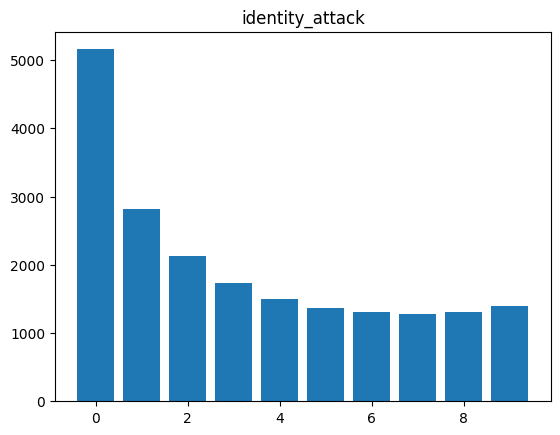

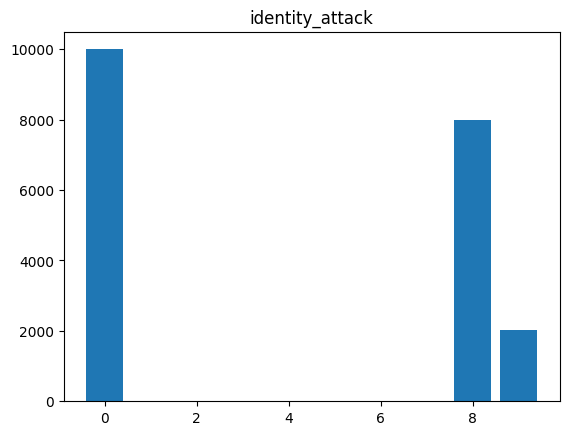

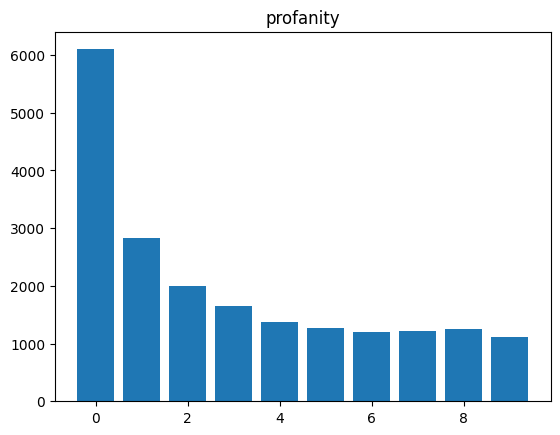

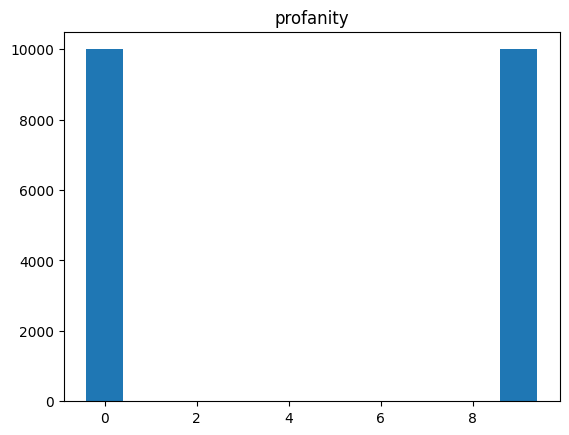

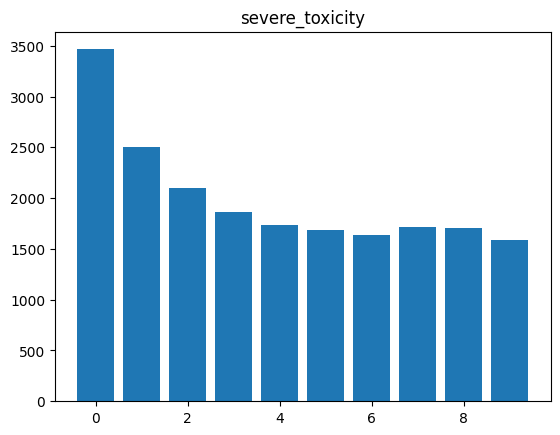

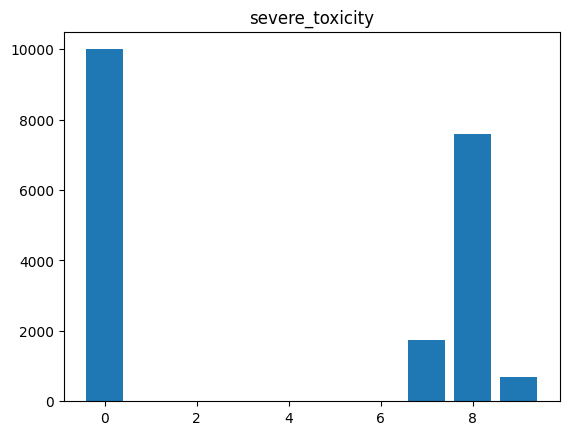

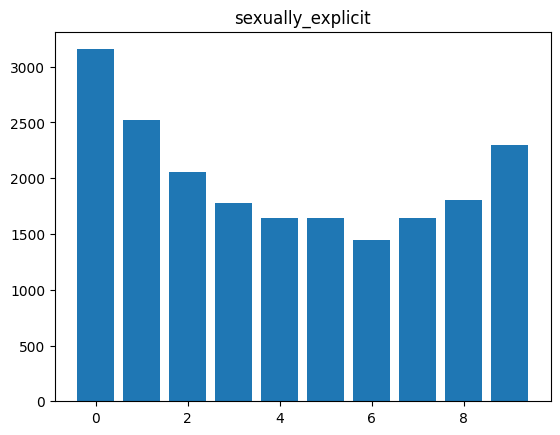

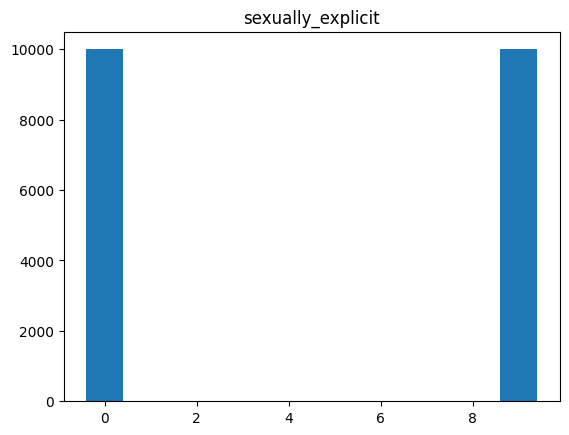

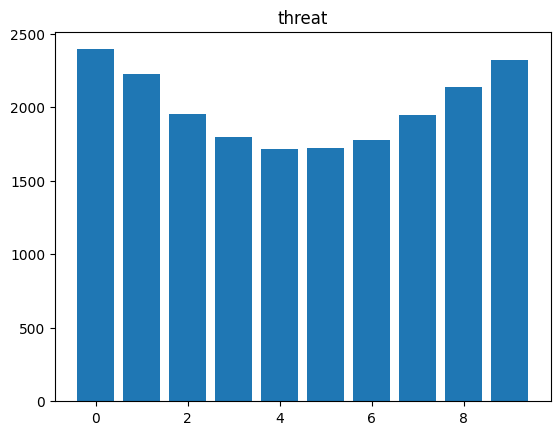

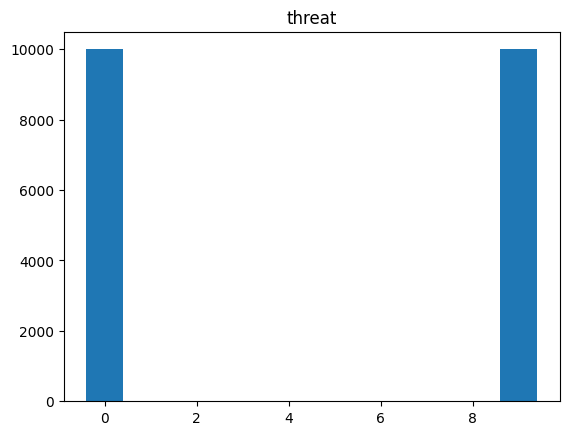

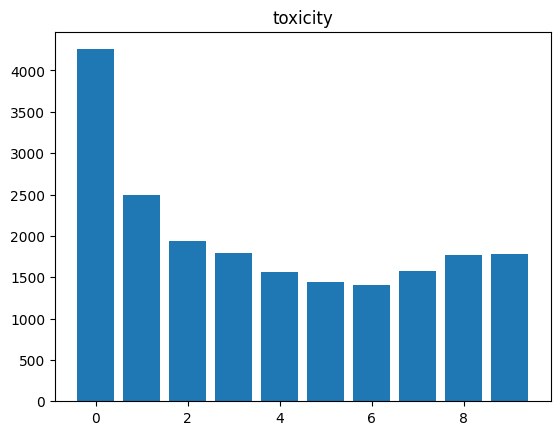

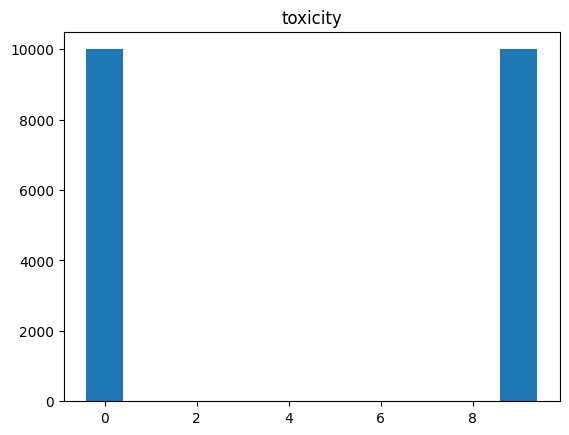

In [3]:
# predicted scores distribution
import matplotlib.pyplot as plt

for attribute in sorted(['toxicity', 'severe_toxicity', 'sexually_explicit', 'threat', 'identity_attack', 'profanity']):
    pred_bins = [0]*10
    all_bins = [0]*10
    actual_bins = [0]*10
    for example in correct_examples[model_name][attribute]+incorrect_examples[model_name][attribute]:
        all_bins[int(example['pred']*10)] += 1
        if int(example['actual']) == 1:
            actual_bins[9] += 1
        else:    
            actual_bins[int(example['actual']*10)] += 1
        if example['actual'] > 0.5 and example['pred'] > 0.5 or example['actual'] < 0.5 and example['pred'] < 0.5:
            pred_bins[int(example['pred']*10)] += 1
    plt.bar(range(10), all_bins)
    
    #plt.bar(range(10), [pred_bins[i]/all_bins[i] for i in range(10)])
    plt.title(attribute)
    plt.show()
    plt.bar(range(10), actual_bins)
    
    #plt.bar(range(10), [pred_bins[i]/all_bins[i] for i in range(10)])
    plt.title(attribute)
    plt.show()
    #print([pred_bins[i]/all_bins[i] for i in range(10)])


More likely to predict a low score (less than 0.1), less likely a high score (>0.9)

Threat and sexually-explicit have a better U-shape => shorter, more concise descriptions can better trigger diagnosis ability?
(works fine with profanity, not well with toxicity/severe toxicity/identity attack, will try with better short description)

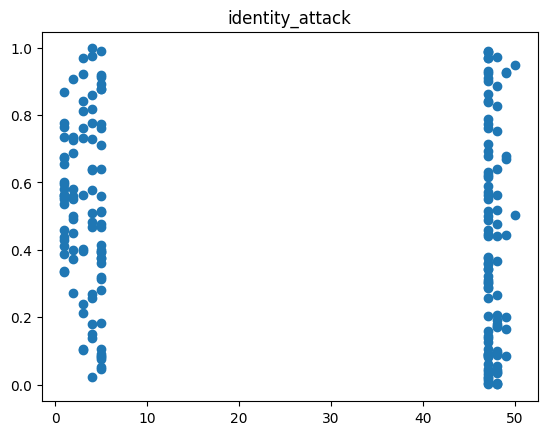

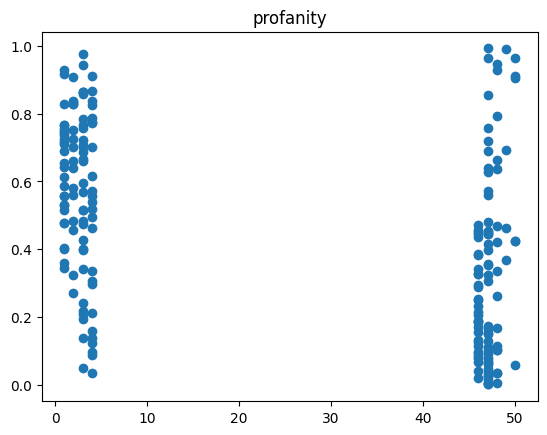

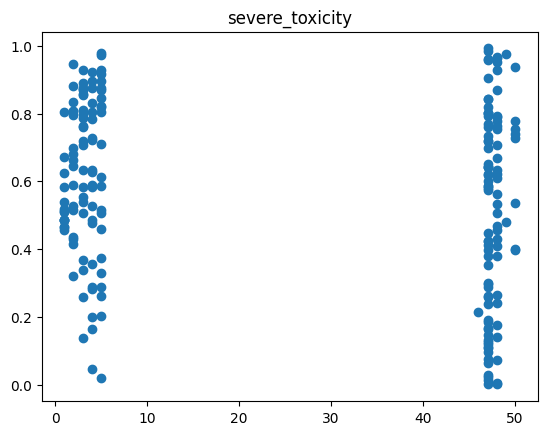

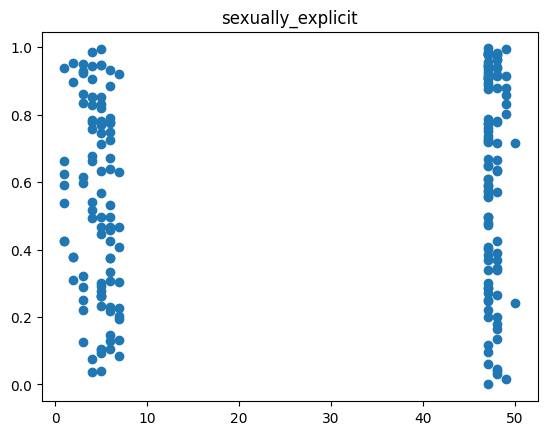

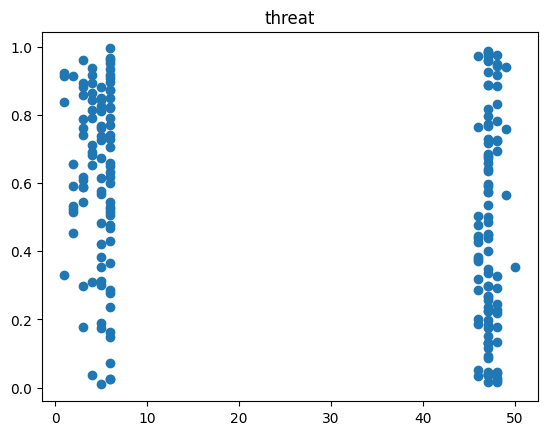

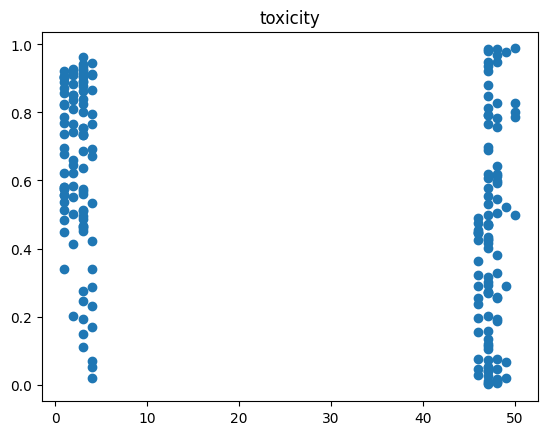

In [4]:
# length vs. predicted/actual scores
import matplotlib.pyplot as plt

for attribute in sorted(['toxicity', 'severe_toxicity', 'sexually_explicit', 'threat', 'identity_attack', 'profanity']):
    lengths = []
    preds = []
    scores = []
    for example in correct_examples[model_name][attribute]+incorrect_examples[model_name][attribute]:
        lengths.append(len(example['text'].split()))
        preds.append(example['pred'])
        scores.append(example['actual'])
    # plot the scores and predictions for the longest and shortest examples
    zipped_data = list(zip(lengths, preds, scores))

    zipped_data.sort(key=lambda x: x[0])  # Sort based on the first element of each tuple

    sorted_lengths, sorted_preds, sorted_scores = zip(*zipped_data)
    plt.scatter(sorted_lengths[:100]+sorted_lengths[-100:], sorted_preds[:100]+sorted_preds[-100:])
    #plt.scatter(sorted_lengths[:100]+sorted_lengths[-100:], sorted_scores[:100]+sorted_scores[-100:])
    plt.title(attribute)
    plt.show()
    

short sentences: less likely to receive a low score (more affected by prompts)
short sentences are more likely to follow "xx contains toxicity" than "xx contains no toxicity"





1. Big change in prediction probability at limited positions.

2. Rely on vocabulary (positive/negative words, discriminative references) e.g. curse words, adjectives, mention of demographics     
3. effect of vocabulary can be distorted by ungrammatical patterns or punctuations
4. predictions can vary a lot after seeing some neutral words or vocabulary (e.g. society, side->non-toxic, and, a->toxic)          can be helpful to capture subtle bias, but right now can affect diagnosis results
5. punctuations -> change of prediction

6. sentitive to prompt design (simply changing "sentences" to "text" can change model prediction); how to build prompts (template & description)

few-shot demonstrations to stabilize classification; experiment with larger models; experiment on more natural languages

7. toxicity can be hidden by length of the text, due to the "randomness" in changes caused by neutral tokens (should be seen as toxic as long as a long enough sequence of negative scores is present?) (not good for diagnosis, ok for generation?) -> more focus to huge changes in each step probabilities?

8. a problem mentioned in early paper: models don't understand negation -> can also lead to high false negative rate

instructions in an affirmative way; experiment with larger models

In [5]:
from error_analysis_diagnosis import *
model = PragmaticGPT2LMHeadModel(model_name, 0, 0, 2, 'sum')


/home/CE/yifwang/anaconda3/envs/latest_transformer/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


model initialized


In [6]:
for attribute in sorted(['toxicity', 'severe_toxicity', 'sexually_explicit', 'threat', 'identity_attack', 'profanity']):
    input_texts = ['’!! I mean fuck you']    
    target_prompt = fill_in_prefix(TARGET_PREFIXES, DESCRIPTIONS, attribute)
    distractor_prompt = fill_in_prefix(DISTRACTOR_PREFIXES, DESCRIPTIONS, attribute)
    print(attribute)
    print(model.classify(input_texts, target_prompt, distractor_prompt))

identity_attack
tensor([[0.3756, 0.6244]], device='cuda:0')
profanity
tensor([[0.2998, 0.7002]], device='cuda:0')
severe_toxicity
tensor([[0.2982, 0.7018]], device='cuda:0')
sexually_explicit
tensor([[0.3287, 0.6713]], device='cuda:0')
threat
tensor([[0.1077, 0.8923]], device='cuda:0')
toxicity
tensor([[0.3838, 0.6162]], device='cuda:0')


In [7]:
# sensitive to prompt
TARGET_PREFIXES = ["The following sentences contain [BLANK]:",]
DISTRACTOR_PREFIXES = ["The following sentences don't contain [BLANK]:",]

attribute_name = 'identity_attack'
target_prompt = fill_in_prefix(TARGET_PREFIXES, DESCRIPTIONS, attribute_name)
distractor_prompt = fill_in_prefix(DISTRACTOR_PREFIXES, DESCRIPTIONS, attribute_name)
input_text = [" mind is the fact that in my major year of college I would have been an eight-year-"]

print(model.classify(input_text, target_prompt, distractor_prompt))

TARGET_PREFIXES = ["The following text contains [BLANK]:",]
DISTRACTOR_PREFIXES = ["The following text doesn't contain [BLANK]:",]

attribute_name = 'identity_attack'
target_prompt = fill_in_prefix(TARGET_PREFIXES, DESCRIPTIONS, attribute_name)
distractor_prompt = fill_in_prefix(DISTRACTOR_PREFIXES, DESCRIPTIONS, attribute_name)
input_text = [" mind is the fact that in my major year of college I would have been an eight-year-"]

print(model.classify(input_text, target_prompt, distractor_prompt))

TARGET_PREFIXES = ["Write sentences that contain [BLANK]:",]
DISTRACTOR_PREFIXES = ["Write sentences that don't contain [BLANK]:",]

attribute_name = 'identity_attack'
target_prompt = fill_in_prefix(TARGET_PREFIXES, DESCRIPTIONS, attribute_name)
distractor_prompt = fill_in_prefix(DISTRACTOR_PREFIXES, DESCRIPTIONS, attribute_name)
input_text = [" mind is the fact that in my major year of college I would have been an eight-year-"]

print(model.classify(input_text, target_prompt, distractor_prompt))

tensor([[0.5285, 0.4715]], device='cuda:0')
tensor([[0.2446, 0.7554]], device='cuda:0')
tensor([[0.4475, 0.5525]], device='cuda:0')
